In [13]:
from pandas_datareader import data
import numpy as np 
import scipy as sp 
import pandas as pd 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.notebook_repr_html', True)

from datetime import date, datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)})  

from cryptocompare import get_daily_trades
from indicators import *

import requests
import talib
import plot

In [ ]:
Todo
- get ohlcv data
- get intraday volatility
    - test for stationarity 
- get rolling(7) volatility for o,h,l,c, intraday spread
- look at distribution
- look at semi deviations 
- get skewness 

In [11]:
prices = get_daily_trades('BTC', all_data=True)
prices['intraday_spread'] = df.high - df.low
prices = prices[[col for col in prices.columns if 'volume' not in col]]

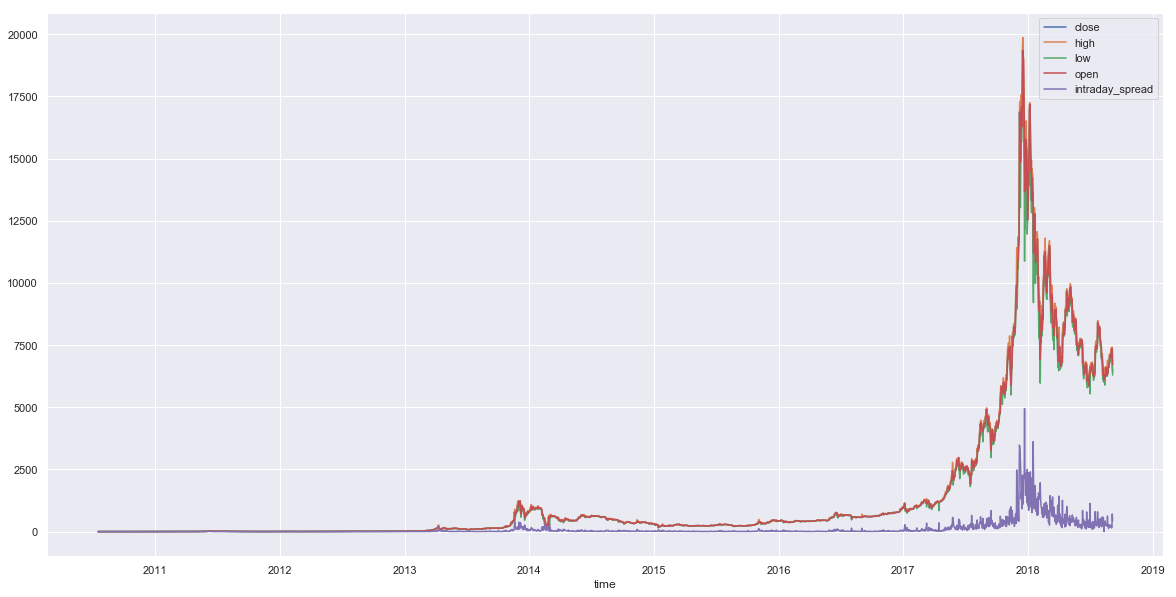

In [14]:
prices.plot()

In [15]:
prices.corr()

,close,high,low,open,intraday_spread
close,1.000000,0.999230,0.998823,0.997923,0.826298
high,0.999230,1.000000,0.998022,0.999029,0.840475
low,0.998823,0.998022,1.000000,0.998081,0.804744
open,0.997923,0.999029,0.998081,1.000000,0.830794
intraday_spread,0.826298,0.840475,0.804744,0.830794,1.000000


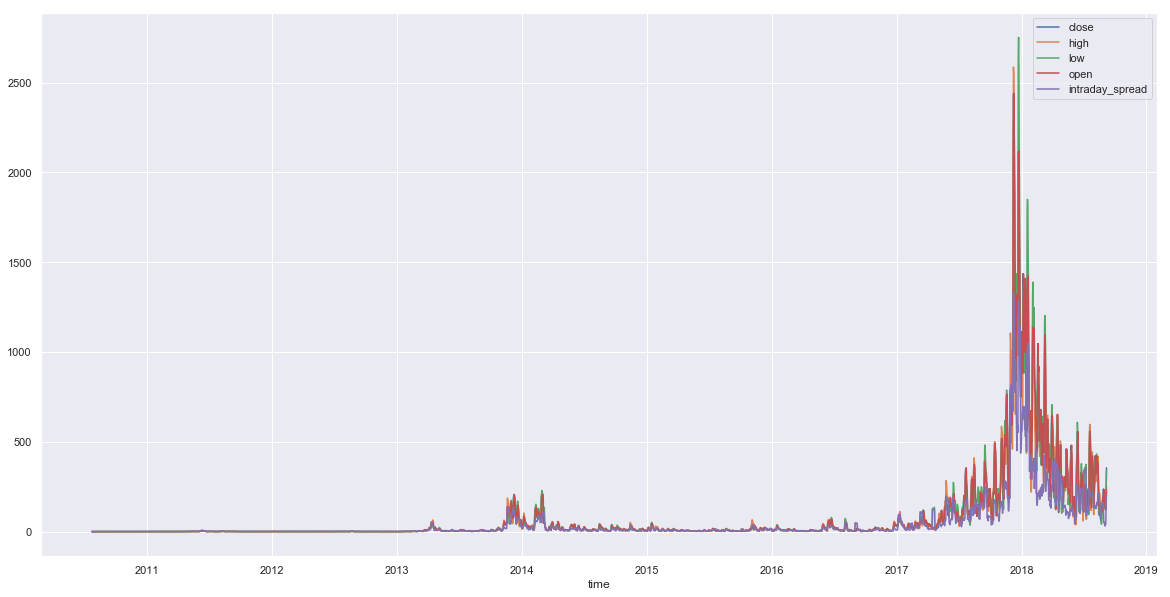

In [16]:
vol = prices.rolling(7).std()
vol.plot()

In [19]:
vol.corr()

,close,high,low,open,intraday_spread
close,1.000000,0.980111,0.961104,0.971945,0.917058
high,0.980111,1.000000,0.928090,0.976342,0.915058
low,0.961104,0.928090,1.000000,0.954894,0.921356
open,0.971945,0.976342,0.954894,1.000000,0.917163
intraday_spread,0.917058,0.915058,0.921356,0.917163,1.000000


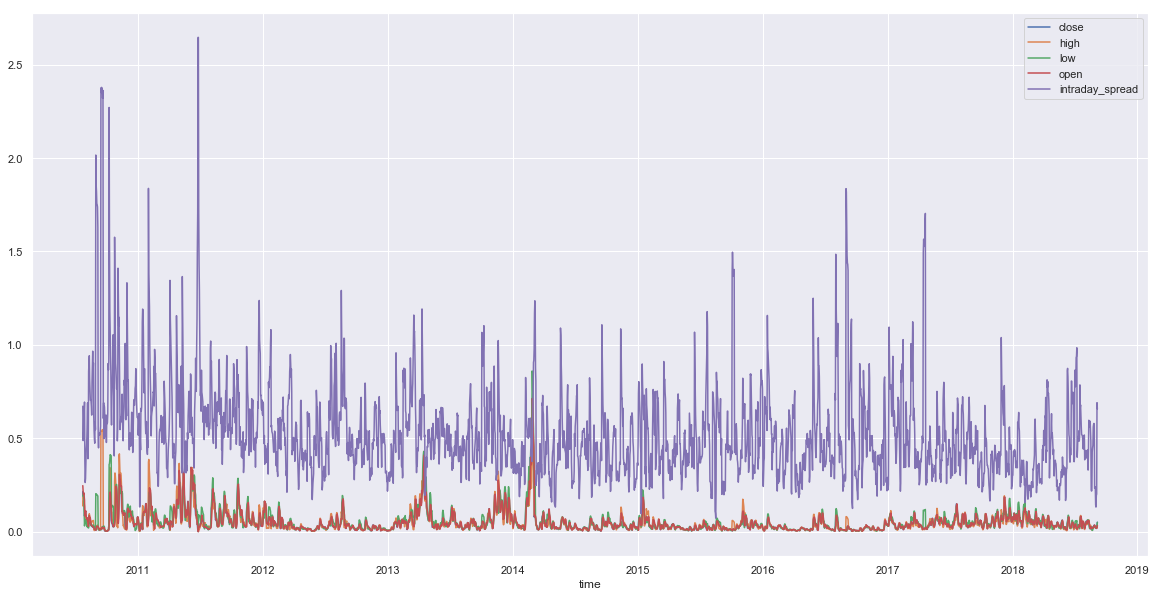

In [58]:
norm_vol = prices.rolling(7).std() / prices.rolling(7).mean()
_ = norm_vol.plot()

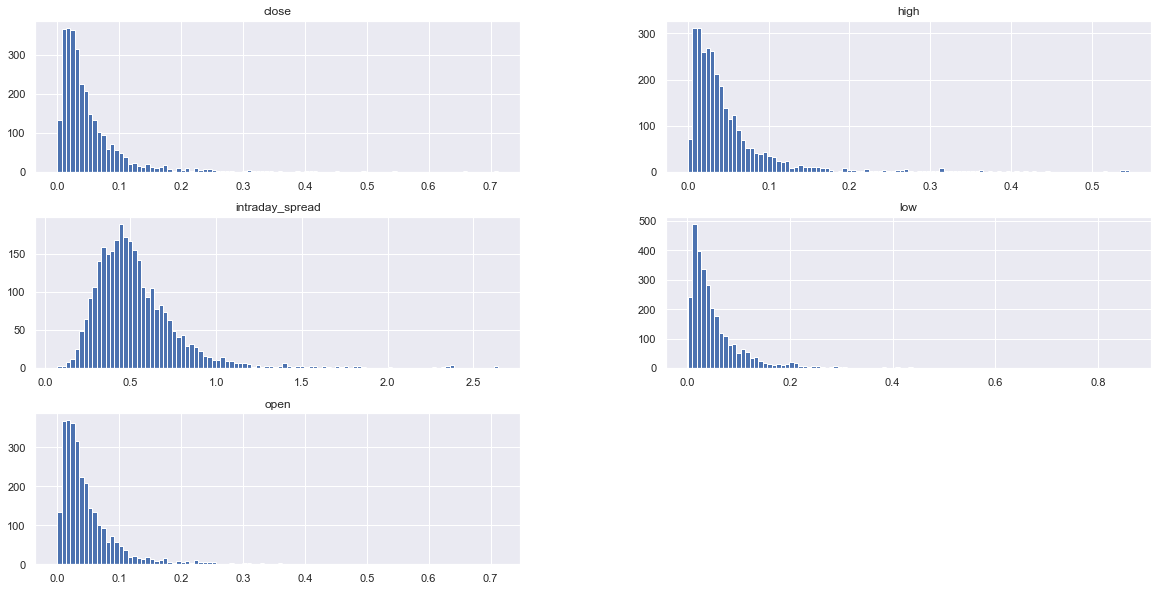

In [63]:
_ = norm_vol.hist(bins=100)

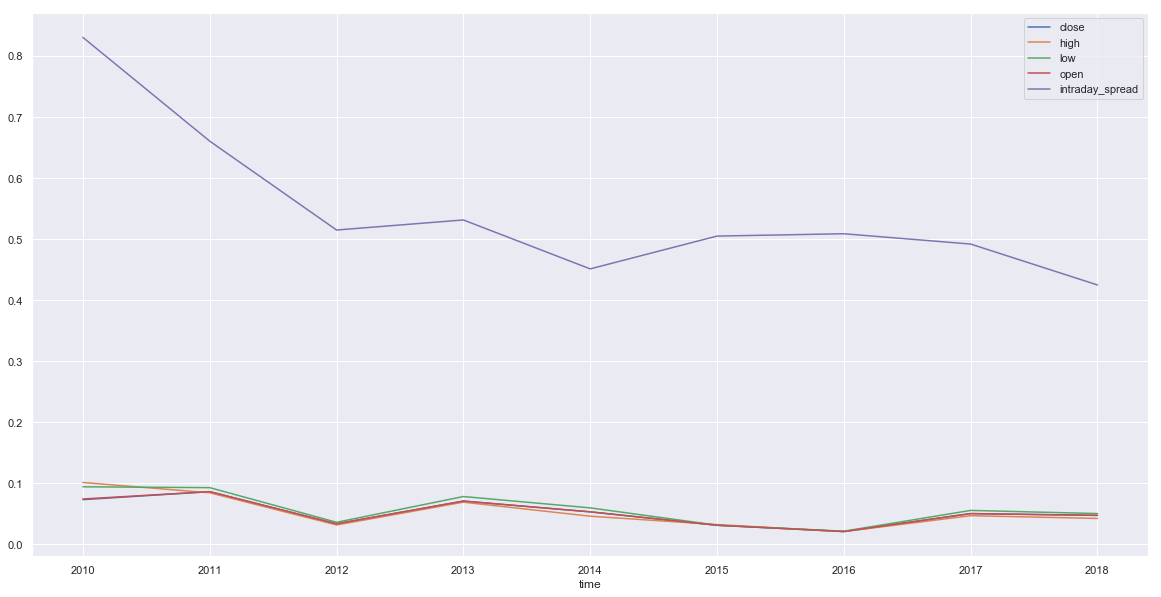

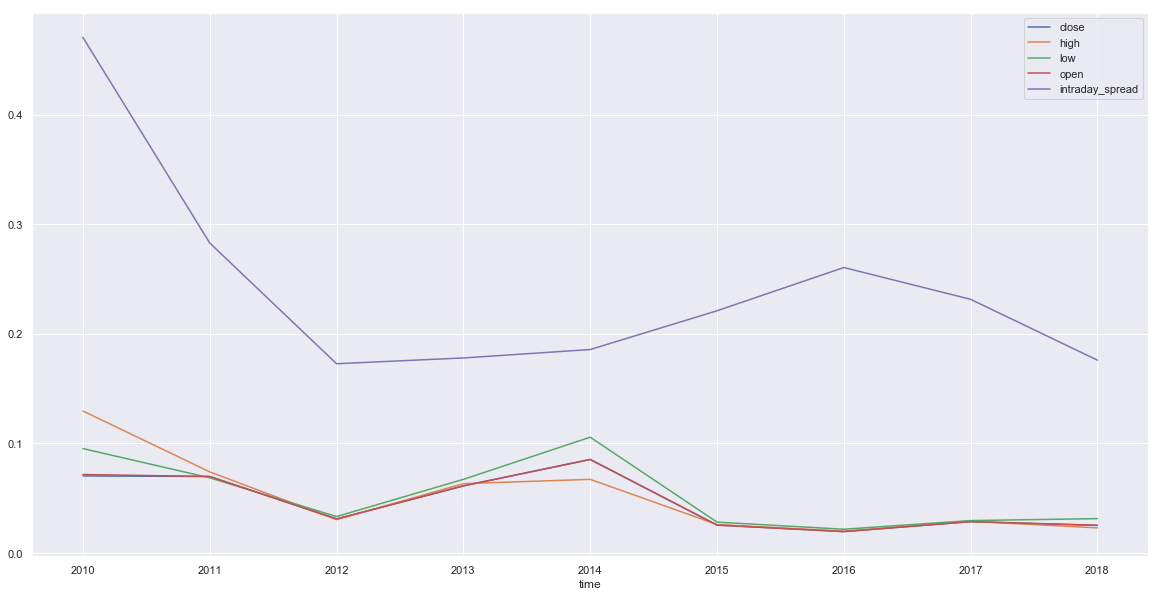

In [67]:
norm_vol.groupby(norm_vol.index.year).mean().plot()
norm_vol.groupby(norm_vol.index.year).std().plot()

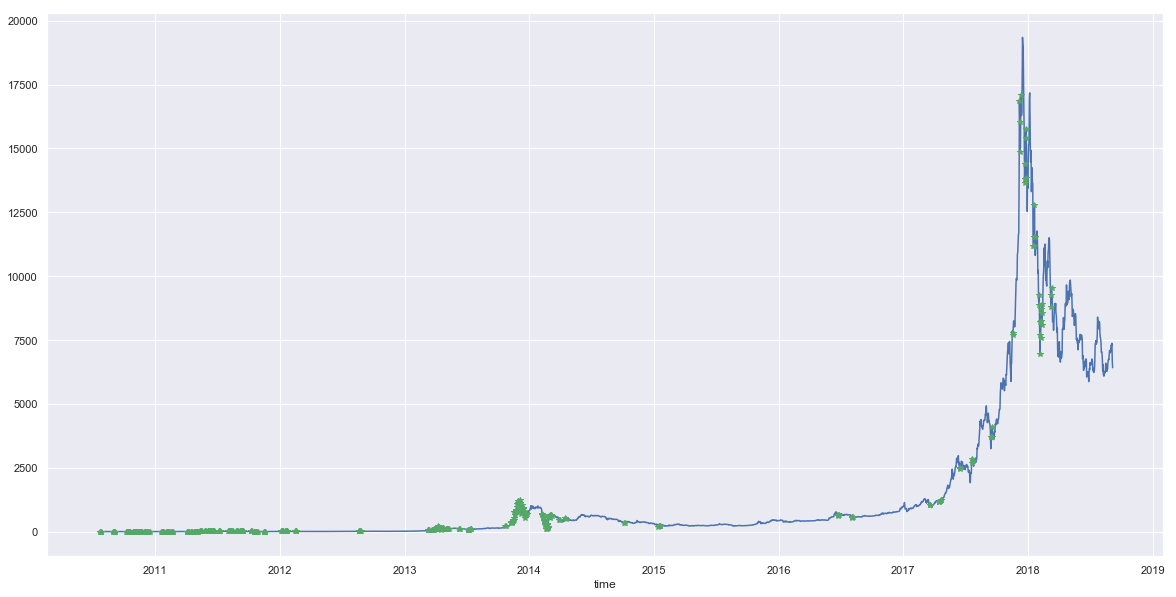

In [73]:
prices.close.plot()
prices[(norm_vol.low > .1)].close.plot(marker='*', ls='', color='g')

### Volatility during bear markets

In [76]:
prices['prev_ath'] = prices.apply(lambda d: prices[:d.name].high.max(), axis=1)
prices['cycle_bottom'] = prices.apply(lambda d: prices[prices[prices.prev_ath==d.prev_ath].index[0]:d.name].low.min(), axis=1)
prices['time_since_ath'] = prices.apply(lambda d: (d.name - prices[prices.prev_ath==d.prev_ath].index[0]).days , axis=1)
prices['time_since_bottom'] = prices.apply(lambda d: (d.name - prices[prices.cycle_bottom==d.cycle_bottom].index[0]).days , axis=1)

In [78]:
prices['retracements'] = prices.apply(lambda d: (d.prev_ath - d.close)/d.prev_ath, axis=1)

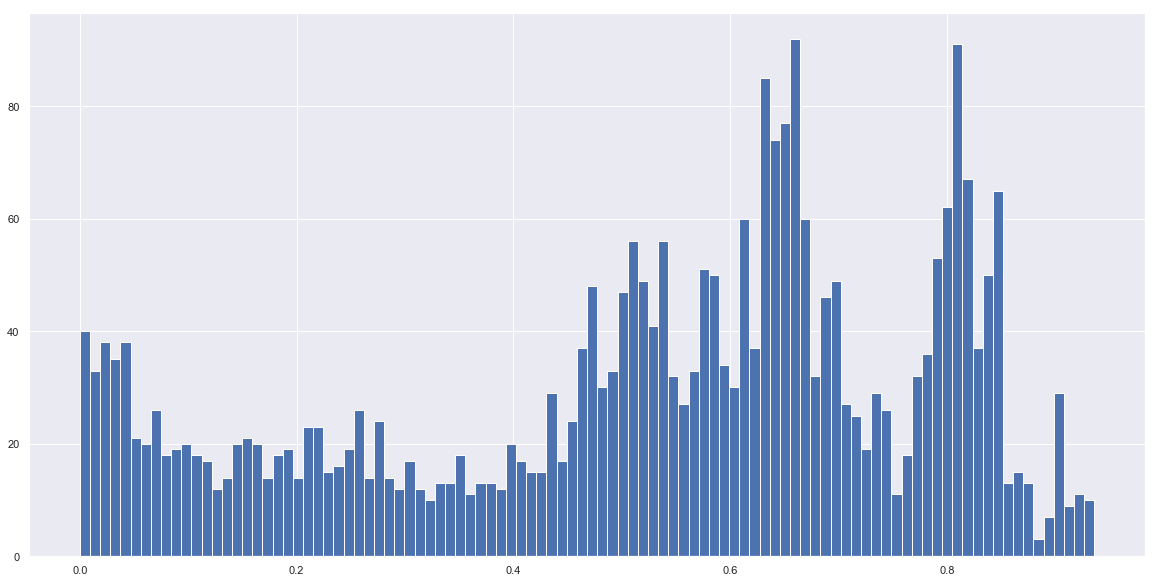

In [79]:
prices.retracements.hist(bins=100)

In [120]:
norm_vol.groupby(prices.retracements // .1).close.describe()

,count,mean,std,min,25%,50%,75%,max
retracements,,,,,,,,
-0.0,301.0,0.078389,0.062480,0.011392,0.034426,0.059621,0.097504,0.343807
1.0,186.0,0.067035,0.055625,0.010668,0.030210,0.046450,0.082054,0.329021
2.0,189.0,0.065901,0.052929,0.009215,0.033722,0.051414,0.076216,0.306388
3.0,143.0,0.057821,0.054128,0.005220,0.020924,0.045738,0.075950,0.305697
4.0,297.0,0.047932,0.047812,0.000000,0.015369,0.031572,0.058740,0.334493
5.0,456.0,0.047695,0.071159,0.001999,0.014417,0.030045,0.051395,0.712455
6.0,632.0,0.035723,0.036934,0.001717,0.014867,0.025848,0.043526,0.408646
7.0,304.0,0.048431,0.051398,0.006813,0.021722,0.033005,0.052209,0.361834
8.0,404.0,0.038488,0.042778,0.001961,0.013622,0.024978,0.049338,0.415711


In [168]:
norm_vol['retracements'] = prices.retracements
grouped_retracements = norm_vol.groupby([norm_vol.index.year, norm_vol.retracements // .1])

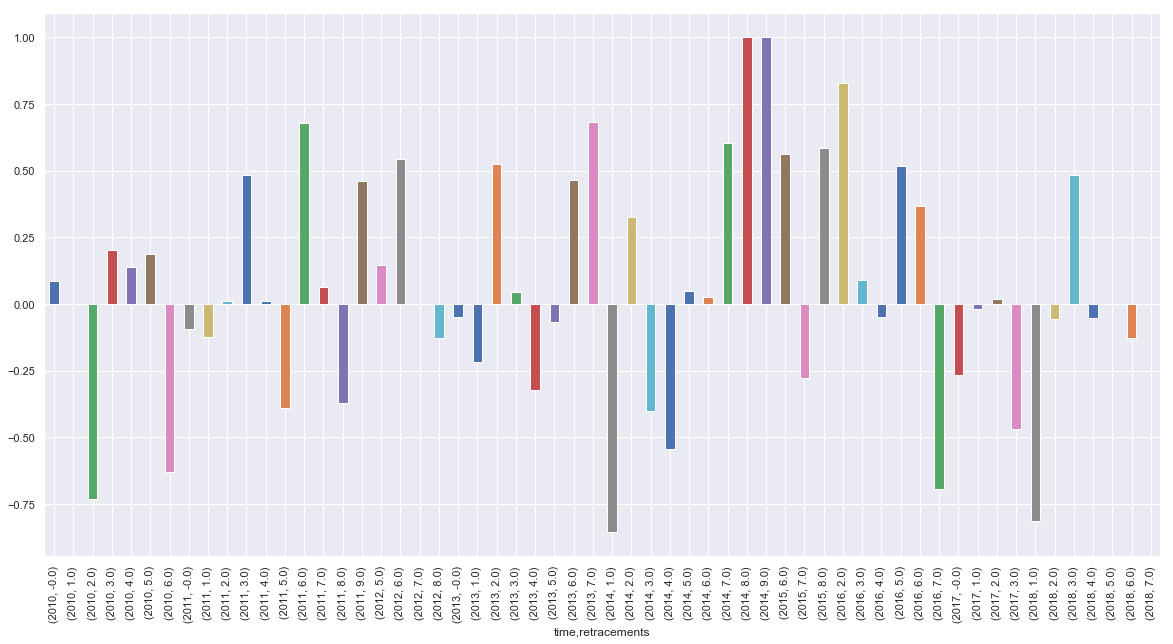

In [169]:
c = grouped_retracements.corr().reset_index(2)
c[c.level_2=='close'].retracements.plot(kind='bar')

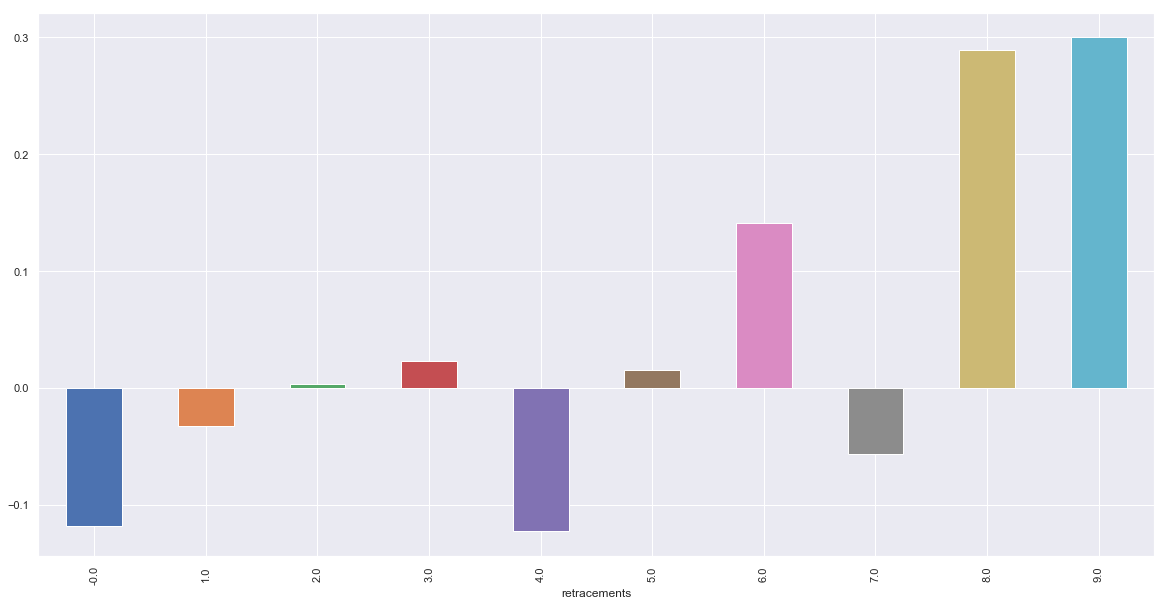

In [166]:
norm_vol['retracements'] = prices.retracements
grouped_retracements = norm_vol.groupby([norm_vol.retracements // .1])
c = grouped_retracements.corr().reset_index(1)
c[c.level_1=='close'].retracements.plot(kind='bar')

In [153]:
c.reset_index(2)

level_2     close      high       low      open  \
time retracements                                                            
2010 -0.0                    close  1.000000  0.747947  0.874912  0.747677   
     -0.0                     high  0.747947  1.000000  0.399032  0.202536   
     -0.0                      low  0.874912  0.399032  1.000000  0.867206   
     -0.0                     open  0.747677  0.202536  0.867206  1.000000   
     -0.0          intraday_spread  0.513365  0.625156  0.482629  0.005222   
     -0.0             retracements  0.088482  0.364682  0.051364 -0.033675   
      1.0                    close       NaN       NaN       NaN       NaN   
      1.0                     high       NaN       NaN       NaN       NaN   
      1.0                      low       NaN       NaN       NaN       NaN   
      1.0                     open       NaN       NaN       NaN       NaN   
      1.0          intraday_spread       NaN       NaN       NaN       NaN   
      1.0             retracements       NaN       NaN       NaN       NaN   
      2.0                    close  1.000000  0.912517  0.829662  0.834810   
      2.0                     high  0.912517  1.000000  0.948324  0.714021   
      2.0                      low  0.829662  0.948324  1.000000  0.686667   
      2.0                     open  0.834810  0.714021  0.686667  1.000000   
      2.0          intraday_spread  0.201056  0.502251  0.550033 -0.030928   
      2.0             retracements -0.729076 -0.655291 -0.475627 -0.591310   
      3.0                    close  1.000000  0.835087  0.478278  0.963136   
      3.0                     high  0.835087  1.000000  0.425986  0.746071   
      3.0                      low  0.478278  0.425986  1.000000  0.463893   
      3.0                     open  0.963136  0.746071  0.463893  1.000000   
      3.0          intraday_spread -0.059489  0.143003  0.611025 -0.139641   
      3.0             retracements  0.204727  0.195913  0.181481  0.250662   
      4.0                    close  1.000000  0.857102  0.724411  0.938493   
      4.0                     high  0.857102  1.000000  0.840923  0.832959   
      4.0                      low  0.724411  0.840923  1.000000  0.762773   
      4.0                     open  0.938493  0.832959  0.762773  1.000000   
      4.0          intraday_spread  0.208211  0.397294  0.491830  0.119962   
      4.0             retracements  0.140068  0.131072  0.006233  0.104024   
      5.0                    close  1.000000  0.948459  0.757827  0.933704   
      5.0                     high  0.948459  1.000000  0.696295  0.925457   
      5.0                      low  0.757827  0.696295  1.000000  0.564299   
      5.0                     open  0.933704  0.925457  0.564299  1.000000   
      5.0          intraday_spread  0.033874  0.017748  0.460175 -0.284112   
      5.0             retracements  0.188784  0.015183  0.087553  0.211561   
      6.0                    close  1.000000  0.135053  0.902292  0.957132   
      6.0                     high  0.135053  1.000000  0.121360  0.138262   
      6.0                      low  0.902292  0.121360  1.000000  0.957092   
      6.0                     open  0.957132  0.138262  0.957092  1.000000   
      6.0          intraday_spread  0.066081  0.988319  0.041983  0.054484   
      6.0             retracements -0.630471  0.299095 -0.490884 -0.520496   
2011 -0.0                    close  1.000000  0.976348  0.859379  0.865905   
     -0.0                     high  0.976348  1.000000  0.824649  0.851599   
     -0.0                      low  0.859379  0.824649  1.000000  0.957571   
     -0.0                     open  0.865905  0.851599  0.957571  1.000000   
     -0.0          intraday_spread  0.286080  0.283354  0.031246  0.069221   
     -0.0             retracements -0.094526 -0.032785  0.010712  0.104396   
      1.0                    close  1.000000  0.970732  0.897915  0.915306   
      1.0                     high  0.970732  1.0

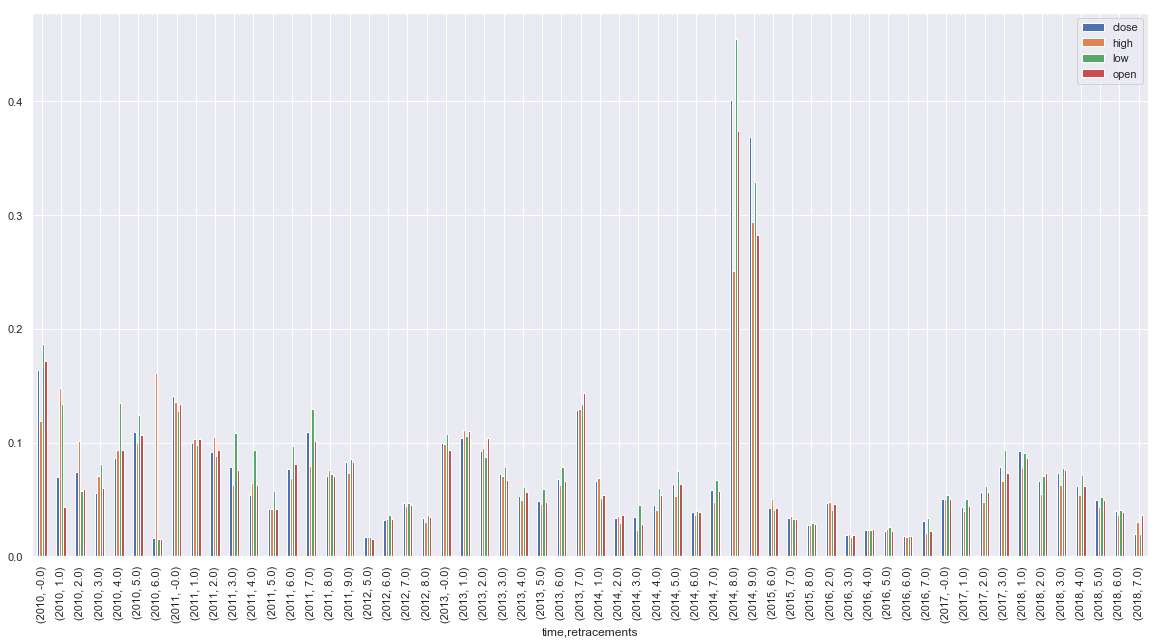

In [129]:
norm_vol.groupby([prices.index.year, prices.retracements // .1]).mean().drop('intraday_spread', axis=1).plot(kind='bar')

In [132]:
prices.columns

Index(['close', 'high', 'low', 'open', 'intraday_spread', 'prev_ath',
       'cycle_bottom', 'time_since_ath', 'time_since_bottom', 'retracements'],
      dtype='object')

In [137]:
prices.prev_ath.unique() // prices.prev_ath.median()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  8.,  9.,
        9.,  9., 11., 13., 13., 14., 14., 14., 15., 15.])

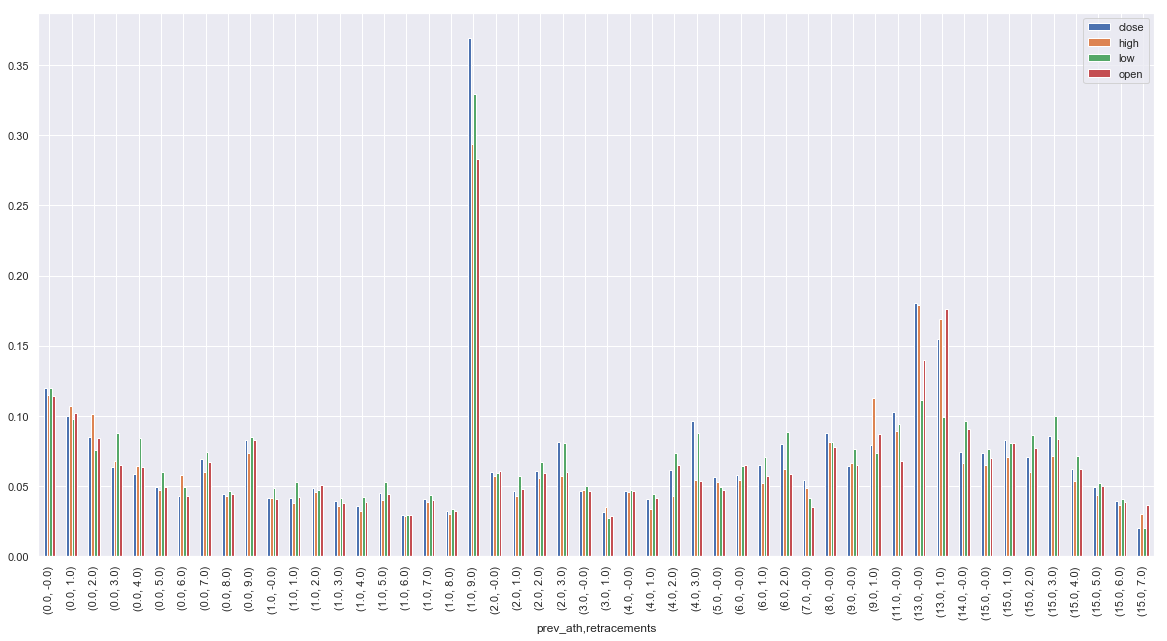

In [139]:
norm_vol.groupby([prices.prev_ath // prices.prev_ath.median(), prices.retracements // .1]).mean().drop('intraday_spread', axis=1).plot(kind='bar')

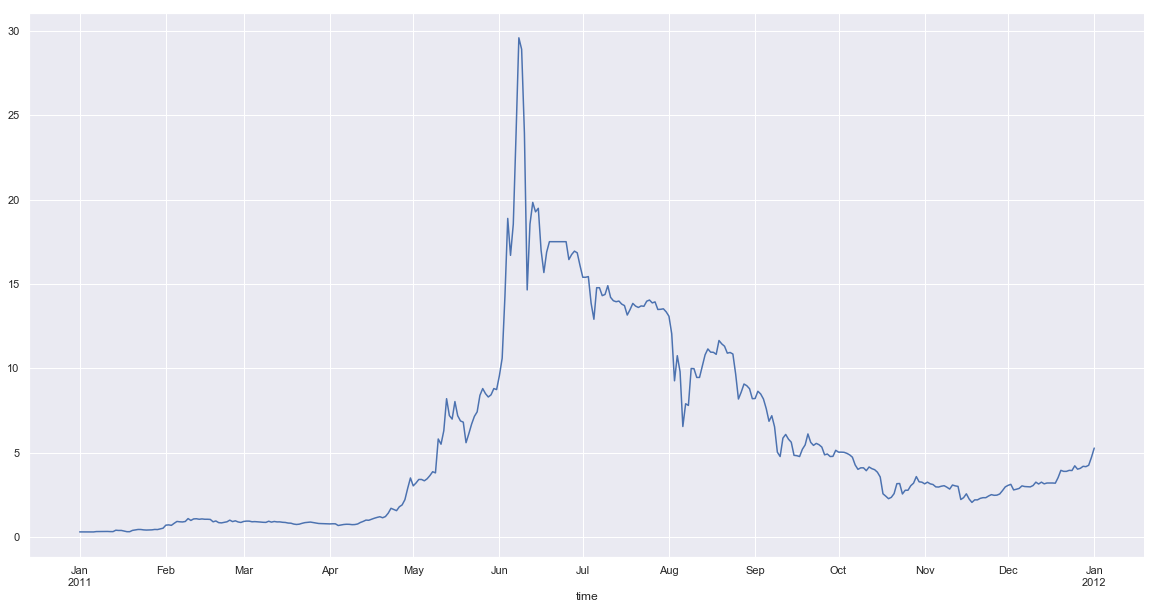

In [131]:
prices[datetime(2011,1,1):datetime(2012,1,1)].close.plot()